# Grating Coupler (Incoming) Surrogate

Improvements
Train shallower angles - greater than 15% not that common

Use larger grating height - fix at 220 nm and include variance over a small range for sensitivity analysis (+/- 10 nm)

Hold up that might be the thickness of the entire stack... Keep reading paper to understand it
    
https://opg.optica.org/oe/fulltext.cfm?uri=oe-23-12-16289&id=320268 seems good. Yannick sent this https://www.mdpi.com/2072-666X/11/7/666

This model is half etched which should improve efficiency - target between 30-50% then 

Modify to include substrate mirror - even if it's only SiO2 on Si

Target 20-30% efficiency for model without substrate mirror at 10% angle (fix angle as well and vary only for sensitivity +/- 5)

Need to understand the effect of increasing the waveguide length - practically smaller would be better I believe

Yannick says that 2D mode solver can analytically optimize for this problem - see messages 02/09 @ 10:30

In [47]:
# basic imports
import numpy as np
import matplotlib.pylab as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver
import tidy3d.plugins.design as tdd

In [48]:
# basic parameters (note, all length units are microns)
nm = 1e-3
wavelength = 1550 * nm

# grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wavelength)

# waveguide
wg_width = 400 * nm
wg_height = 220 * nm
wg_length = 2 * wavelength

# surrounding
sub_height = 2.0
air_height = 2.0
buffer = 0.5 * wavelength

# coupler
cp_width = 4 * wavelength
cp_length = 8 * wavelength
taper_length = 6 * wavelength

# sizes
Lx = buffer + wg_length + taper_length + cp_length
Ly = buffer + cp_width + buffer
Lz = sub_height + wg_height + air_height
sim_size = [Lx, Ly, Lz]

# convenience variables to store center of coupler and waveguide
wg_center_x = +Lx / 2 - buffer - (wg_length + taper_length) / 2
cp_center_x = -Lx / 2 + buffer + cp_length / 2
wg_center_z = -Lz / 2 + sub_height + wg_height / 2
cp_center_z = -Lz / 2 + sub_height + wg_height / 2

# materials
Air = td.Medium(permittivity=1.0)
Si = td.Medium(permittivity=3.47**2)
SiO2 = td.Medium(permittivity=1.44**2)

# source parameters
freq0 = td.C_0 / wavelength
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = freq0 / 10
run_time = 100 / fwidth

In [49]:
def make_sim(beam_angle, cp_width, cp_length, taper_length, grating_height):
    # param conversions
    cp_width = cp_width * wavelength
    cp_length = cp_length * wavelength
    taper_length = taper_length * wavelength

    # grating parameters
    design_theta_rad = np.pi * beam_angle / 180
    grating_height = grating_height * nm

    # do a mode solve to get neff of the coupler

    sub = td.Structure(
        geometry=td.Box(center=[0, 0, -Lz / 2], size=[td.inf, td.inf, 2 * sub_height]),
        medium=SiO2,
        name="substrate",
    )

    cp = td.Structure(
        geometry=td.Box(
            center=[0, 0, cp_center_z - grating_height / 4],
            size=[td.inf, cp_width, wg_height - grating_height / 2],
        ),
        medium=Si,
        name="coupler",
    )

    mode_plane = td.Box(center=(0, 0, 0), size=(0, 8 * cp_width, 8 * wg_height))


    sim = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[sub, cp],
        sources=[],
        monitors=[],
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        run_time=1e-12,
    )

    # Updating n_eff with frequency breaks the whole idea of broadband single simulations
    # So there will be a drift of n_eff as f gets further away from freq0
    ms = ModeSolver(
        simulation=sim, plane=mode_plane, mode_spec=td.ModeSpec(), freqs=[freq0]
    )
    mode_output = ms.solve()
    neff = float(mode_output.n_eff)

    # Build simulation
    pitch = wavelength / (neff - np.sin(abs(design_theta_rad)))
    grating_length = pitch / 2.0
    num_gratings = int(cp_length / pitch)

    sub = td.Structure(
        geometry=td.Box(
            center=[0, 0, -Lz / 2],
            size=[td.inf, td.inf, 2 * sub_height],
        ),
        medium=SiO2,
        name="substrate",
    )

    wg = td.Structure(
        geometry=td.Box(
            center=[wg_center_x, 0, wg_center_z],
            size=[buffer + wg_length + taper_length + cp_length / 2, wg_width, wg_height],
        ),
        medium=Si,
        name="waveguide",
    )

    cp = td.Structure(
        geometry=td.Box(
            center=[cp_center_x, 0, cp_center_z],
            size=[cp_length, cp_width, wg_height],
        ),
        medium=Si,
        name="coupler",
    )

    tp = td.Structure(
        geometry=td.PolySlab(
            vertices=[
                [cp_center_x + cp_length / 2 + taper_length, +wg_width / 2],
                [cp_center_x + cp_length / 2 + taper_length, -wg_width / 2],
                [cp_center_x + cp_length / 2, -cp_width / 2],
                [cp_center_x + cp_length / 2, +cp_width / 2],
            ],
            slab_bounds=(wg_center_z - wg_height / 2, wg_center_z + wg_height / 2),
            axis=2,
        ),
        medium=Si,
        name="taper",
    )

    grating_left_x = cp_center_x - cp_length / 2
    gratings = [
        td.Structure(
            geometry=td.Box(
                center=[
                    grating_left_x + (i + 0.5) * pitch,
                    0,
                    cp_center_z + wg_height / 2 - grating_height / 2,
                ],
                size=[grating_length, cp_width, grating_height],
            ),
            medium=Air,
            name=f"{i}th_grating",
        )
        for i in range(num_gratings)
    ]

    gaussian_beam = td.GaussianBeam(
        size=(td.inf, td.inf, 0),
        center=[-8, 0, 2],
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        angle_theta=design_theta_rad,
        angle_phi=np.pi,
        direction="-",
        waist_radius=2,
        pol_angle=np.pi / 2,
    )

    flux_mon = td.FluxMonitor(
        center=(Lx / 2 - 1, 0, wg_center_z), 
        size=(0, wg_width * 2, wg_height * 2),
        freqs=freqs,
        name="flux",
    )

    sim = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[sub, wg, cp, tp] + gratings,
        sources=[gaussian_beam],
        monitors=[flux_mon],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    )

    return sim

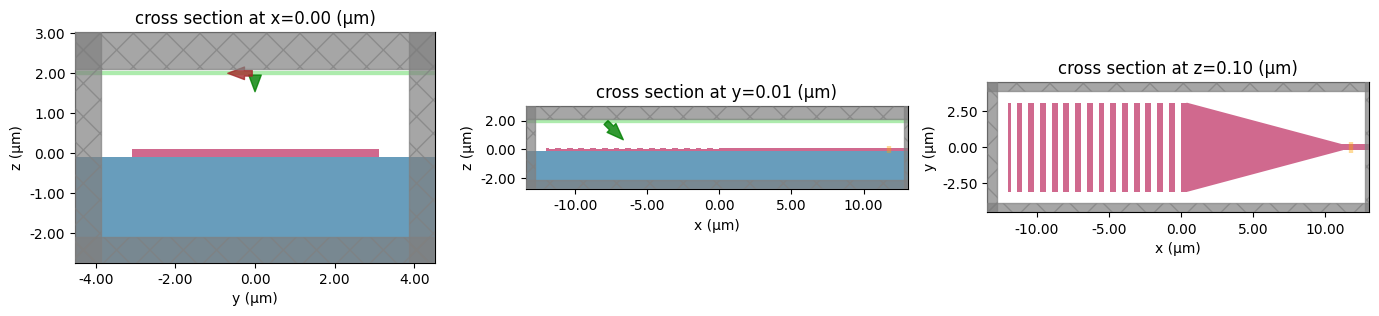

In [50]:
sim=make_sim(45, 4, 8, 7, 100)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(14, 3))
sim.plot(x=0, ax=ax1)
sim.plot(y=0.01, ax=ax2)
sim.plot(z=0.1, ax=ax3)
plt.show()

In [51]:
def fn_post(sim_data):
    return {"wg_flux": sim_data["flux"].flux}

In [54]:
param_beam_angle = tdd.ParameterFloat(name="beam_angle", span=(15, 45))
param_cp_width = tdd.ParameterFloat(name="cp_width", span=(3, 4))
param_cp_length = tdd.ParameterFloat(name="cp_length", span=(7, 8))
param_taper_length = tdd.ParameterFloat(name="taper_length", span=(5, 7))
param_grating_height = tdd.ParameterFloat(name="grating_height", span=(50, 100))
parameters = [param_beam_angle, param_cp_width, param_cp_length, param_taper_length, param_grating_height]

monte_carlo=tdd.MethodMonteCarlo(
    num_points=100,
    seed=2,
)

design_space = tdd.DesignSpace(method=monte_carlo, parameters=parameters, task_name="GC_MC_Surrogate", path_dir="/home/matt/Documents/Flexcompute/grating_coupler/data")

In [55]:
# Run the MC
results = design_space.run(make_sim, fn_post, verbose=True)
df = results.to_dataframe()

10:58:27 BST Running 100 Simulations

In [56]:
# TESTING: Save off the df or load the df
import pickle
import os
os.chdir("/home/matt/Documents/Flexcompute/grating_coupler/data")
# with open("result_100.pkl", "wb") as out_file:
#     pickle.dump(results, out_file)


with open("result_100.pkl", "rb") as in_file:
    results = pickle.load(in_file)

df = results.to_dataframe()

## Surrogate

In [57]:
expanded_df = df.copy()
expanded_df = expanded_df.explode(["wg_flux"]).reset_index(drop=True)
expanded_df["freq"] = expanded_df["wg_flux"].apply(lambda x: float(x.f))

expanded_df["wg_flux"] = expanded_df["wg_flux"].apply(lambda x: float(x))

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim

from tidy3d.plugins.design.surrogate_object import AI_Model

# Constants
output_dir = "/home/matt/Documents/Flexcompute/grating_coupler"
data_dir = ["/home/matt/Documents/Flexcompute/grating_coupler/data/"]

test_percentage = 0.20
valid_percentage = 0.20
batch_size = 256
epochs = 100

trial_count = 50

model = AI_Model(output_dir, data_dir, seed=2)

model.load_data_from_df(
    df=expanded_df,
    label_names=["wg_flux"],
    feature_names=["beam_angle", "cp_width", "cp_length", "taper_length", "grating_height", "freq"],
    test_percentage=test_percentage,
    valid_percentage=valid_percentage,
    batch_size=batch_size,
    individual_feature_scaling=True
)

loss_fn = nn.MSELoss()

Using existing directory at pickle_data
Using existing directory at models
Using device cuda:0


In [59]:
# Define the model in PyTorch
class VariableANN(nn.Module):
    def __init__(self, input_size, neurons, dropout) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, neurons[0]))

        for i in range(1, len(neurons)):
            self.layers.append(nn.Linear(neurons[i - 1], neurons[i]))

        self.layers.append(nn.Linear(neurons[-1], 1))

        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.drop(self.relu(layer(x)))

        x = self.layers[-1](x)

        return x

Using existing directory at Model1


  3%|▎         | 3/100 [00:00<00:03, 26.19it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 2
Best State Updated. Epoch: 3
Best State Updated. Epoch: 4


  7%|▋         | 7/100 [00:00<00:03, 29.79it/s]

Best State Updated. Epoch: 5
Best State Updated. Epoch: 6
Best State Updated. Epoch: 7


 10%|█         | 10/100 [00:00<00:04, 19.20it/s]

Best State Updated. Epoch: 8
Best State Updated. Epoch: 9
Best State Updated. Epoch: 10
Best State Updated. Epoch: 11
Best State Updated. Epoch: 12


 14%|█▍        | 14/100 [00:00<00:03, 23.44it/s]

Best State Updated. Epoch: 13
Best State Updated. Epoch: 14


 18%|█▊        | 18/100 [00:00<00:03, 26.48it/s]

Best State Updated. Epoch: 15
Best State Updated. Epoch: 16
Best State Updated. Epoch: 17
Best State Updated. Epoch: 18
Best State Updated. Epoch: 19


 21%|██        | 21/100 [00:00<00:02, 26.39it/s]

Best State Updated. Epoch: 20


 25%|██▌       | 25/100 [00:00<00:02, 27.98it/s]

Best State Updated. Epoch: 21
Best State Updated. Epoch: 22
Best State Updated. Epoch: 24
Best State Updated. Epoch: 25


 33%|███▎      | 33/100 [00:01<00:02, 30.26it/s]

Best State Updated. Epoch: 28
Best State Updated. Epoch: 29
Best State Updated. Epoch: 30
Best State Updated. Epoch: 32


 41%|████      | 41/100 [00:01<00:01, 32.63it/s]

Best State Updated. Epoch: 36
Best State Updated. Epoch: 40


 49%|████▉     | 49/100 [00:01<00:01, 29.98it/s]

Best State Updated. Epoch: 44
Best State Updated. Epoch: 46
Best State Updated. Epoch: 48


 57%|█████▋    | 57/100 [00:01<00:01, 31.74it/s]

Best State Updated. Epoch: 50
Best State Updated. Epoch: 51


 65%|██████▌   | 65/100 [00:02<00:01, 32.37it/s]

Best State Updated. Epoch: 60


 81%|████████  | 81/100 [00:02<00:00, 29.06it/s]

Best State Updated. Epoch: 74
Best State Updated. Epoch: 78
Best State Updated. Epoch: 80


 85%|████████▌ | 85/100 [00:02<00:00, 29.10it/s]

Best State Updated. Epoch: 82
Best State Updated. Epoch: 87


 96%|█████████▌| 96/100 [00:03<00:00, 29.56it/s]

Best State Updated. Epoch: 90
Best State Updated. Epoch: 91


100%|██████████| 100/100 [00:03<00:00, 30.61it/s]

Best State Updated. Epoch: 99


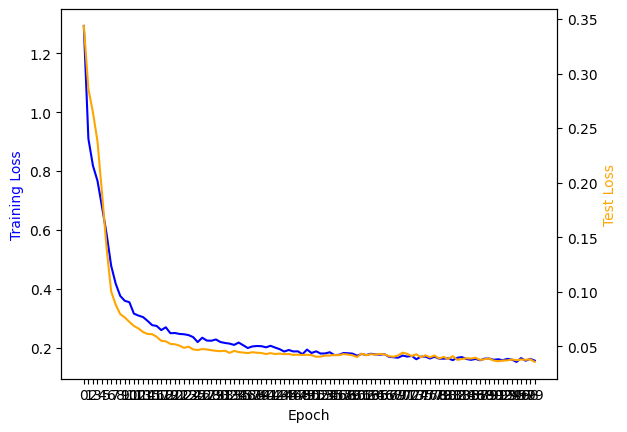

100%|██████████| 100/100 [00:03<00:00, 27.96it/s]

 Best Test Loss: 0.0358317568898201
RMSE: 0.008135
MAE: 0.005537


In [83]:
# Create single model
network = VariableANN(6, [16, 16, 16], 0.2)
opt = optim.Adam(network.parameters(), lr=0.001, weight_decay=0.0001)

trained_net = model.train_model("Model1", network, opt, loss_fn, epochs, plot_output=True)
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")

[I 2024-09-01 11:35:17,278] A new study created in memory with name: no-name-47c8ba5b-b16d-4b84-936b-fae86dc98ad6


Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.17it/s]
[I 2024-09-01 11:35:20,717] Trial 0 finished with value: 0.00925 and parameters: {'dropout': 0.2, 'neurons0': 16, 'neurons1': 144, 'neurons2': 112, 'neurons3': 112, 'lr': 0.00020957490791939475, 'weight_decay': 2.56623998836808e-05}. Best is trial 0 with value: 0.00925.


 Best Test Loss: 0.04378792643547058
RMSE: 0.00925
MAE: 0.007231
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.88it/s]
[I 2024-09-01 11:35:24,074] Trial 1 finished with value: 0.009586 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 80, 'neurons1': 80, 'neurons2': 160, 'neurons3': 144, 'lr': 3.453979704854047e-05, 'weight_decay': 0.00010645259250245113}. Best is trial 0 with value: 0.00925.


 Best Test Loss: 0.049695469439029694
RMSE: 0.009586
MAE: 0.006568
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.64it/s]
[I 2024-09-01 11:35:27,575] Trial 2 finished with value: 0.006326 and parameters: {'dropout': 0.1, 'neurons0': 208, 'neurons1': 224, 'neurons2': 128, 'neurons3': 224, 'lr': 2.0824851253449582e-05, 'weight_decay': 0.0001024453334191056}. Best is trial 2 with value: 0.006326.


 Best Test Loss: 0.02165256068110466
RMSE: 0.006326
MAE: 0.003594
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 31.38it/s]
[I 2024-09-01 11:35:30,771] Trial 3 finished with value: 0.003727 and parameters: {'dropout': 0.0, 'neurons0': 112, 'neurons1': 32, 'neurons2': 48, 'neurons3': 160, 'lr': 8.017666774803345e-05, 'weight_decay': 1.6364071508075995e-05}. Best is trial 3 with value: 0.003727.


 Best Test Loss: 0.007498088292777538
RMSE: 0.003727
MAE: 0.002255
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.88it/s]
[I 2024-09-01 11:35:34,242] Trial 4 finished with value: 0.002539 and parameters: {'dropout': 0.1, 'neurons0': 96, 'neurons1': 128, 'neurons2': 64, 'neurons3': 176, 'lr': 0.0008556168765786835, 'weight_decay': 0.00010244091290412624}. Best is trial 4 with value: 0.002539.


 Best Test Loss: 0.0034488567616790533
RMSE: 0.002539
MAE: 0.001808
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.95it/s]
[I 2024-09-01 11:35:37,714] Trial 5 finished with value: 0.012783 and parameters: {'dropout': 0.2, 'neurons0': 208, 'neurons1': 160, 'neurons2': 48, 'neurons3': 192, 'lr': 0.0721446814835575, 'weight_decay': 0.00010000385053531142}. Best is trial 4 with value: 0.002539.


 Best Test Loss: 0.03991164639592171
RMSE: 0.012783
MAE: 0.009044
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.11it/s]
[I 2024-09-01 11:35:41,164] Trial 6 finished with value: 0.008304 and parameters: {'dropout': 0.45, 'neurons0': 96, 'neurons1': 160, 'neurons2': 112, 'neurons3': 112, 'lr': 0.012771348031164653, 'weight_decay': 0.00011781710498405417}. Best is trial 4 with value: 0.002539.


 Best Test Loss: 0.027263063937425613
RMSE: 0.008304
MAE: 0.005814
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 27.70it/s]
[I 2024-09-01 11:35:44,784] Trial 7 finished with value: 0.01139 and parameters: {'dropout': 0.5, 'neurons0': 144, 'neurons1': 32, 'neurons2': 96, 'neurons3': 224, 'lr': 0.00042179378105206954, 'weight_decay': 1.1334561723036805e-05}. Best is trial 4 with value: 0.002539.


 Best Test Loss: 0.06752928346395493
RMSE: 0.01139
MAE: 0.008105
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.88it/s]
[I 2024-09-01 11:35:48,140] Trial 8 finished with value: 0.004868 and parameters: {'dropout': 0.1, 'neurons0': 32, 'neurons1': 256, 'neurons2': 256, 'neurons3': 208, 'lr': 0.0025542798985646654, 'weight_decay': 0.00033878152677157994}. Best is trial 4 with value: 0.002539.


 Best Test Loss: 0.012180901132524014
RMSE: 0.004868
MAE: 0.003109
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 27.86it/s]
[I 2024-09-01 11:35:51,738] Trial 9 finished with value: 0.007578 and parameters: {'dropout': 0.05, 'neurons0': 80, 'neurons1': 144, 'neurons2': 96, 'neurons3': 16, 'lr': 0.08562760193073449, 'weight_decay': 7.633256192478052e-05}. Best is trial 4 with value: 0.002539.


 Best Test Loss: 0.025117602199316025
RMSE: 0.007578
MAE: 0.005002
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.84it/s]
[I 2024-09-01 11:35:55,109] Trial 10 finished with value: 0.008363 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 160, 'neurons1': 96, 'neurons2': 16, 'neurons3': 64, 'lr': 0.0023435510642152513, 'weight_decay': 0.0007498580827111435}. Best is trial 4 with value: 0.002539.


 Best Test Loss: 0.03207944706082344
RMSE: 0.008363
MAE: 0.005509
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 30.06it/s]
[I 2024-09-01 11:35:58,456] Trial 11 finished with value: 0.004839 and parameters: {'dropout': 0.0, 'neurons0': 112, 'neurons1': 16, 'neurons2': 48, 'neurons3': 160, 'lr': 9.775111800102661e-05, 'weight_decay': 3.786765186441698e-05}. Best is trial 4 with value: 0.002539.


 Best Test Loss: 0.012680311687290668
RMSE: 0.004839
MAE: 0.002672
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 31.41it/s]
[I 2024-09-01 11:36:01,659] Trial 12 finished with value: 0.000909 and parameters: {'dropout': 0.0, 'neurons0': 256, 'neurons1': 80, 'neurons2': 176, 'neurons3': 256, 'lr': 0.0009353634446277074, 'weight_decay': 1.1679403277101083e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.0004455758025869727
RMSE: 0.000909
MAE: 0.000649
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.04it/s]
[I 2024-09-01 11:36:05,121] Trial 13 finished with value: 0.00347 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 256, 'neurons1': 96, 'neurons2': 176, 'neurons3': 256, 'lr': 0.0009815616324252794, 'weight_decay': 0.000250281943316076}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.006297567393630743
RMSE: 0.00347
MAE: 0.002253
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 30.39it/s]
[I 2024-09-01 11:36:08,431] Trial 14 finished with value: 0.001491 and parameters: {'dropout': 0.0, 'neurons0': 256, 'neurons1': 64, 'neurons2': 208, 'neurons3': 256, 'lr': 0.007573810270855609, 'weight_decay': 4.233047899241224e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.000992253073491156
RMSE: 0.001491
MAE: 0.001031
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 31.14it/s]
[I 2024-09-01 11:36:11,662] Trial 15 finished with value: 0.001852 and parameters: {'dropout': 0.0, 'neurons0': 256, 'neurons1': 64, 'neurons2': 224, 'neurons3': 256, 'lr': 0.012411888954267826, 'weight_decay': 2.8761212294685718e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.0016683452995494008
RMSE: 0.001852
MAE: 0.001358
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.07it/s]
[I 2024-09-01 11:36:15,121] Trial 16 finished with value: 0.00776 and parameters: {'dropout': 0.25, 'neurons0': 208, 'neurons1': 64, 'neurons2': 192, 'neurons3': 256, 'lr': 0.008815427933961544, 'weight_decay': 5.026366553642984e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.019135842099785805
RMSE: 0.00776
MAE: 0.006391
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.23it/s]
[I 2024-09-01 11:36:18,562] Trial 17 finished with value: 0.001916 and parameters: {'dropout': 0.05, 'neurons0': 176, 'neurons1': 112, 'neurons2': 208, 'neurons3': 208, 'lr': 0.004060265091669461, 'weight_decay': 1.021988466746451e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.0010549521539360285
RMSE: 0.001916
MAE: 0.001562
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.33it/s]
[I 2024-09-01 11:36:22,114] Trial 18 finished with value: 0.017467 and parameters: {'dropout': 0.4, 'neurons0': 240, 'neurons1': 48, 'neurons2': 240, 'neurons3': 240, 'lr': 0.04284375972976386, 'weight_decay': 1.8377385533642846e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.13234631717205048
RMSE: 0.017467
MAE: 0.013698
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.99it/s]
[I 2024-09-01 11:36:25,468] Trial 19 finished with value: 0.007143 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 224, 'neurons1': 192, 'neurons2': 160, 'neurons3': 64, 'lr': 0.03168823029893868, 'weight_decay': 5.051796782441351e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.019446704536676407
RMSE: 0.007143
MAE: 0.00539
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.75it/s]
[I 2024-09-01 11:36:28,966] Trial 20 finished with value: 0.002886 and parameters: {'dropout': 0.05, 'neurons0': 192, 'neurons1': 80, 'neurons2': 208, 'neurons3': 192, 'lr': 0.0003916273783839293, 'weight_decay': 0.00019582116431703122}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.004492918029427528
RMSE: 0.002886
MAE: 0.001824
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.47it/s]
[I 2024-09-01 11:36:32,379] Trial 21 finished with value: 0.001742 and parameters: {'dropout': 0.0, 'neurons0': 256, 'neurons1': 64, 'neurons2': 224, 'neurons3': 256, 'lr': 0.012202593341400447, 'weight_decay': 2.855349890182945e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.0012092647375538945
RMSE: 0.001742
MAE: 0.001263
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.66it/s]
[I 2024-09-01 11:36:35,772] Trial 22 finished with value: 0.001297 and parameters: {'dropout': 0.0, 'neurons0': 240, 'neurons1': 48, 'neurons2': 256, 'neurons3': 240, 'lr': 0.004737111565643917, 'weight_decay': 1.846732357560528e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.0007061886135488749
RMSE: 0.001297
MAE: 0.000975
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 27.41it/s]
[I 2024-09-01 11:36:39,440] Trial 23 finished with value: 0.002845 and parameters: {'dropout': 0.05, 'neurons0': 224, 'neurons1': 16, 'neurons2': 256, 'neurons3': 224, 'lr': 0.0053188215059409545, 'weight_decay': 1.607065013002349e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.0033340079244226217
RMSE: 0.002845
MAE: 0.002052
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.32it/s]
[I 2024-09-01 11:36:42,991] Trial 24 finished with value: 0.003343 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 240, 'neurons1': 48, 'neurons2': 176, 'neurons3': 240, 'lr': 0.002384307496101178, 'weight_decay': 2.00366108469271e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.002812307793647051
RMSE: 0.003343
MAE: 0.002884
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 30.32it/s]
[I 2024-09-01 11:36:46,309] Trial 25 finished with value: 0.001716 and parameters: {'dropout': 0.0, 'neurons0': 240, 'neurons1': 112, 'neurons2': 224, 'neurons3': 240, 'lr': 0.001379539677699615, 'weight_decay': 5.460649666929721e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.0008550031343474984
RMSE: 0.001716
MAE: 0.001282
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.63it/s]
[I 2024-09-01 11:36:49,705] Trial 26 finished with value: 0.005003 and parameters: {'dropout': 0.1, 'neurons0': 176, 'neurons1': 48, 'neurons2': 192, 'neurons3': 208, 'lr': 0.025327858086566905, 'weight_decay': 1.3357962577881534e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.01204338762909174
RMSE: 0.005003
MAE: 0.003563
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 27.61it/s]
[I 2024-09-01 11:36:53,347] Trial 27 finished with value: 0.001894 and parameters: {'dropout': 0.05, 'neurons0': 224, 'neurons1': 80, 'neurons2': 240, 'neurons3': 224, 'lr': 0.005110419186736545, 'weight_decay': 2.3129655510105765e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.0013153384206816554
RMSE: 0.001894
MAE: 0.001396
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.58it/s]
[I 2024-09-01 11:36:56,866] Trial 28 finished with value: 0.002802 and parameters: {'dropout': 0.2, 'neurons0': 256, 'neurons1': 112, 'neurons2': 144, 'neurons3': 192, 'lr': 0.0006977459918968538, 'weight_decay': 4.041400341512774e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.0031659703236073256
RMSE: 0.002802
MAE: 0.001961
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 30.14it/s]
[I 2024-09-01 11:37:00,204] Trial 29 finished with value: 0.008172 and parameters: {'dropout': 0.25, 'neurons0': 32, 'neurons1': 32, 'neurons2': 192, 'neurons3': 112, 'lr': 0.00020810232634242625, 'weight_decay': 2.954991766652869e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.03423888236284256
RMSE: 0.008172
MAE: 0.005507
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.59it/s]
[I 2024-09-01 11:37:03,604] Trial 30 finished with value: 0.000933 and parameters: {'dropout': 0.0, 'neurons0': 192, 'neurons1': 96, 'neurons2': 256, 'neurons3': 240, 'lr': 0.0015443843943941096, 'weight_decay': 1.3404167056859742e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.00045118987327441573
RMSE: 0.000933
MAE: 0.000668
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 30.90it/s]
[I 2024-09-01 11:37:06,861] Trial 31 finished with value: 0.001221 and parameters: {'dropout': 0.0, 'neurons0': 192, 'neurons1': 96, 'neurons2': 256, 'neurons3': 240, 'lr': 0.0017467632729799491, 'weight_decay': 1.3899594518367367e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.0004513517487794161
RMSE: 0.001221
MAE: 0.000956
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.66it/s]
[I 2024-09-01 11:37:10,372] Trial 32 finished with value: 0.001802 and parameters: {'dropout': 0.05, 'neurons0': 192, 'neurons1': 96, 'neurons2': 256, 'neurons3': 240, 'lr': 0.0015612091760230594, 'weight_decay': 1.3697117645819244e-05}. Best is trial 12 with value: 0.000909.


 Best Test Loss: 0.001020717085339129
RMSE: 0.001802
MAE: 0.001424
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 30.51it/s]
[I 2024-09-01 11:37:13,673] Trial 33 finished with value: 0.000883 and parameters: {'dropout': 0.0, 'neurons0': 192, 'neurons1': 128, 'neurons2': 240, 'neurons3': 224, 'lr': 0.00043997903622784484, 'weight_decay': 1.0343266448769873e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.0004030427080579102
RMSE: 0.000883
MAE: 0.000642
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.53it/s]
[I 2024-09-01 11:37:17,200] Trial 34 finished with value: 0.002301 and parameters: {'dropout': 0.1, 'neurons0': 144, 'neurons1': 128, 'neurons2': 240, 'neurons3': 144, 'lr': 0.00023700651256855222, 'weight_decay': 1.0124491501227216e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.0028424246702343225
RMSE: 0.002301
MAE: 0.001688
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.70it/s]
[I 2024-09-01 11:37:20,704] Trial 35 finished with value: 0.0037 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 176, 'neurons1': 160, 'neurons2': 240, 'neurons3': 176, 'lr': 0.0004456105481507006, 'weight_decay': 1.3187727908986592e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.005925264209508896
RMSE: 0.0037
MAE: 0.002738
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.07it/s]
[I 2024-09-01 11:37:24,287] Trial 36 finished with value: 0.009356 and parameters: {'dropout': 0.1, 'neurons0': 160, 'neurons1': 192, 'neurons2': 224, 'neurons3': 208, 'lr': 1.0215185404600834e-05, 'weight_decay': 1.3884018083066353e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.04737653583288193
RMSE: 0.009356
MAE: 0.006297
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.88it/s]
[I 2024-09-01 11:37:27,656] Trial 37 finished with value: 0.001671 and parameters: {'dropout': 0.0, 'neurons0': 128, 'neurons1': 128, 'neurons2': 160, 'neurons3': 176, 'lr': 0.00010436723656960968, 'weight_decay': 2.2408731512662882e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.001500140642747283
RMSE: 0.001671
MAE: 0.001074
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 30.20it/s]
[I 2024-09-01 11:37:30,989] Trial 38 finished with value: 0.00389 and parameters: {'dropout': 0.05, 'neurons0': 192, 'neurons1': 176, 'neurons2': 144, 'neurons3': 224, 'lr': 4.271993045275549e-05, 'weight_decay': 1.5551864630774073e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.00817309319972992
RMSE: 0.00389
MAE: 0.002277
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.53it/s]
[I 2024-09-01 11:37:34,396] Trial 39 finished with value: 0.001739 and parameters: {'dropout': 0.1, 'neurons0': 160, 'neurons1': 96, 'neurons2': 256, 'neurons3': 224, 'lr': 0.0006650122146027906, 'weight_decay': 1.0319743731242423e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.001622902462258935
RMSE: 0.001739
MAE: 0.001322
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.72it/s]
[I 2024-09-01 11:37:37,782] Trial 40 finished with value: 0.006371 and parameters: {'dropout': 0.2, 'neurons0': 208, 'neurons1': 144, 'neurons2': 240, 'neurons3': 128, 'lr': 0.0002375063078972982, 'weight_decay': 0.0009323594058951285}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.021779906004667282
RMSE: 0.006371
MAE: 0.003546
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.51it/s]
[I 2024-09-01 11:37:41,310] Trial 41 finished with value: 0.000941 and parameters: {'dropout': 0.0, 'neurons0': 224, 'neurons1': 112, 'neurons2': 256, 'neurons3': 240, 'lr': 0.0013593539874805934, 'weight_decay': 1.8382039446917996e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.0004771103849634528
RMSE: 0.000941
MAE: 0.000694
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 30.00it/s]
[I 2024-09-01 11:37:44,665] Trial 42 finished with value: 0.001075 and parameters: {'dropout': 0.0, 'neurons0': 224, 'neurons1': 112, 'neurons2': 256, 'neurons3': 240, 'lr': 0.0013339458660440605, 'weight_decay': 1.2388980423253209e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.0003924832271877676
RMSE: 0.001075
MAE: 0.000779
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.93it/s]
[I 2024-09-01 11:37:48,143] Trial 43 finished with value: 0.001452 and parameters: {'dropout': 0.05, 'neurons0': 224, 'neurons1': 128, 'neurons2': 224, 'neurons3': 192, 'lr': 0.0009702282347567407, 'weight_decay': 2.4108227612958717e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.0008751087007112801
RMSE: 0.001452
MAE: 0.00109
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.85it/s]
[I 2024-09-01 11:37:51,514] Trial 44 finished with value: 0.001161 and parameters: {'dropout': 0.0, 'neurons0': 208, 'neurons1': 112, 'neurons2': 112, 'neurons3': 80, 'lr': 0.00047249326874799656, 'weight_decay': 1.2254142784859899e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.0006133334245532751
RMSE: 0.001161
MAE: 0.000835
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.42it/s]
[I 2024-09-01 11:37:54,934] Trial 45 finished with value: 0.002006 and parameters: {'dropout': 0.05, 'neurons0': 224, 'neurons1': 80, 'neurons2': 240, 'neurons3': 256, 'lr': 0.002958046832033718, 'weight_decay': 1.6567318695556225e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.0011500774417072535
RMSE: 0.002006
MAE: 0.001616
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.45it/s]
[I 2024-09-01 11:37:58,359] Trial 46 finished with value: 0.001209 and parameters: {'dropout': 0.0, 'neurons0': 240, 'neurons1': 160, 'neurons2': 208, 'neurons3': 224, 'lr': 0.0013554357803856167, 'weight_decay': 3.288235103508033e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.0006268168799579144
RMSE: 0.001209
MAE: 0.000852
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.97it/s]
[I 2024-09-01 11:38:01,832] Trial 47 finished with value: 0.005273 and parameters: {'dropout': 0.1, 'neurons0': 192, 'neurons1': 128, 'neurons2': 128, 'neurons3': 16, 'lr': 0.00016327408705200022, 'weight_decay': 1.949980546096506e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.007843115366995335
RMSE: 0.005273
MAE: 0.004093
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 29.03it/s]
[I 2024-09-01 11:38:05,298] Trial 48 finished with value: 0.006231 and parameters: {'dropout': 0.5, 'neurons0': 208, 'neurons1': 112, 'neurons2': 80, 'neurons3': 208, 'lr': 0.0005746621277081667, 'weight_decay': 1.1432961845554118e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.018257224932312965
RMSE: 0.006231
MAE: 0.004726
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:03<00:00, 28.95it/s]
[I 2024-09-01 11:38:08,775] Trial 49 finished with value: 0.002689 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 224, 'neurons1': 256, 'neurons2': 256, 'neurons3': 256, 'lr': 0.00030120805756722087, 'weight_decay': 7.335777425163355e-05}. Best is trial 33 with value: 0.000883.


 Best Test Loss: 0.0034421011805534363
RMSE: 0.002689
MAE: 0.001915
Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  0
  Number of complete trials:  50
Best trial:
  Value:  0.000883
  Params: 
    dropout: 0.0
    neurons0: 192
    neurons1: 128
    neurons2: 240
    neurons3: 224
    lr: 0.00043997903622784484
    weight_decay: 1.0343266448769873e-05
Using existing directory at Model1


  0%|          | 4/1000 [00:00<00:32, 30.90it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 2
Best State Updated. Epoch: 3
Best State Updated. Epoch: 4
Best State Updated. Epoch: 5


  1%|          | 8/1000 [00:00<00:49, 20.11it/s]

Best State Updated. Epoch: 6
Best State Updated. Epoch: 7


  1%|          | 11/1000 [00:00<00:44, 22.06it/s]

Best State Updated. Epoch: 8
Best State Updated. Epoch: 9
Best State Updated. Epoch: 10
Best State Updated. Epoch: 11


  1%|▏         | 14/1000 [00:00<00:41, 23.97it/s]

Best State Updated. Epoch: 12
Best State Updated. Epoch: 13


  2%|▏         | 17/1000 [00:00<00:38, 25.23it/s]

Best State Updated. Epoch: 14
Best State Updated. Epoch: 15
Best State Updated. Epoch: 16
Best State Updated. Epoch: 17


  2%|▏         | 20/1000 [00:00<00:37, 25.91it/s]

Best State Updated. Epoch: 18
Best State Updated. Epoch: 19


  2%|▏         | 24/1000 [00:00<00:34, 27.90it/s]

Best State Updated. Epoch: 20
Best State Updated. Epoch: 21
Best State Updated. Epoch: 22
Best State Updated. Epoch: 23
Best State Updated. Epoch: 24
Best State Updated. Epoch: 25
Best State Updated. Epoch: 26


  3%|▎         | 28/1000 [00:01<00:33, 29.01it/s]

Best State Updated. Epoch: 27
Best State Updated. Epoch: 28
Best State Updated. Epoch: 29
Best State Updated. Epoch: 30


  3%|▎         | 32/1000 [00:01<00:33, 28.61it/s]

Best State Updated. Epoch: 31
Best State Updated. Epoch: 32


  4%|▎         | 35/1000 [00:01<00:33, 28.60it/s]

Best State Updated. Epoch: 33
Best State Updated. Epoch: 34
Best State Updated. Epoch: 35
Best State Updated. Epoch: 36


  4%|▍         | 39/1000 [00:01<00:32, 29.36it/s]

Best State Updated. Epoch: 37
Best State Updated. Epoch: 38
Best State Updated. Epoch: 39


  4%|▍         | 42/1000 [00:01<00:35, 27.28it/s]

Best State Updated. Epoch: 40
Best State Updated. Epoch: 41
Best State Updated. Epoch: 42


  4%|▍         | 45/1000 [00:01<00:34, 27.43it/s]

Best State Updated. Epoch: 43
Best State Updated. Epoch: 44
Best State Updated. Epoch: 45


  5%|▍         | 49/1000 [00:01<00:33, 28.65it/s]

Best State Updated. Epoch: 46
Best State Updated. Epoch: 47
Best State Updated. Epoch: 48
Best State Updated. Epoch: 49


  5%|▌         | 52/1000 [00:01<00:33, 27.93it/s]

Best State Updated. Epoch: 50
Best State Updated. Epoch: 51


  6%|▌         | 55/1000 [00:02<00:33, 28.33it/s]

Best State Updated. Epoch: 52
Best State Updated. Epoch: 53
Best State Updated. Epoch: 54
Best State Updated. Epoch: 55
Best State Updated. Epoch: 56


  6%|▋         | 63/1000 [00:02<00:30, 30.48it/s]

Best State Updated. Epoch: 60
Best State Updated. Epoch: 61
Best State Updated. Epoch: 62
Best State Updated. Epoch: 63


  7%|▋         | 67/1000 [00:02<00:33, 28.20it/s]

Best State Updated. Epoch: 66


  8%|▊         | 75/1000 [00:02<00:36, 25.54it/s]

Best State Updated. Epoch: 70
Best State Updated. Epoch: 71


 10%|▉         | 95/1000 [00:03<00:30, 30.12it/s]

Best State Updated. Epoch: 90
Best State Updated. Epoch: 91


 10%|█         | 103/1000 [00:03<00:29, 30.90it/s]

Best State Updated. Epoch: 99


 12%|█▏        | 123/1000 [00:04<00:27, 32.15it/s]

Best State Updated. Epoch: 119
Best State Updated. Epoch: 123
Best State Updated. Epoch: 124
Best State Updated. Epoch: 125


 13%|█▎        | 131/1000 [00:04<00:27, 32.07it/s]

Best State Updated. Epoch: 126
Best State Updated. Epoch: 127
Best State Updated. Epoch: 128
Best State Updated. Epoch: 129


 16%|█▌        | 155/1000 [00:05<00:27, 30.90it/s]

Best State Updated. Epoch: 150
Best State Updated. Epoch: 151
Best State Updated. Epoch: 152


 18%|█▊        | 179/1000 [00:06<00:25, 31.75it/s]

Best State Updated. Epoch: 175
Best State Updated. Epoch: 176
Best State Updated. Epoch: 177


 20%|██        | 203/1000 [00:07<00:29, 27.31it/s]

Best State Updated. Epoch: 198


 24%|██▎       | 235/1000 [00:08<00:25, 30.33it/s]

Best State Updated. Epoch: 229
Best State Updated. Epoch: 231
Best State Updated. Epoch: 233
Best State Updated. Epoch: 235


 28%|██▊       | 278/1000 [00:09<00:24, 29.76it/s]

Best State Updated. Epoch: 273
Best State Updated. Epoch: 274
Best State Updated. Epoch: 275
Best State Updated. Epoch: 276


 29%|██▉       | 293/1000 [00:10<00:23, 29.49it/s]

Best State Updated. Epoch: 287
Best State Updated. Epoch: 288


 32%|███▏      | 317/1000 [00:10<00:21, 32.13it/s]

Best State Updated. Epoch: 313
Best State Updated. Epoch: 314
Best State Updated. Epoch: 315


 35%|███▌      | 353/1000 [00:12<00:20, 31.18it/s]

Best State Updated. Epoch: 347
Best State Updated. Epoch: 348
Best State Updated. Epoch: 350


 44%|████▎     | 437/1000 [00:14<00:17, 32.31it/s]

Best State Updated. Epoch: 430
Best State Updated. Epoch: 431
Best State Updated. Epoch: 432


 54%|█████▎    | 537/1000 [00:18<00:15, 30.34it/s]

Best State Updated. Epoch: 533
Best State Updated. Epoch: 534
Best State Updated. Epoch: 535
Best State Updated. Epoch: 537


 62%|██████▎   | 625/1000 [00:20<00:12, 30.09it/s]

Best State Updated. Epoch: 621
Best State Updated. Epoch: 622
Best State Updated. Epoch: 623


 73%|███████▎  | 733/1000 [00:24<00:08, 30.43it/s]

Best State Updated. Epoch: 728


 78%|███████▊  | 784/1000 [00:26<00:07, 27.47it/s]

Best State Updated. Epoch: 778


 84%|████████▍ | 839/1000 [00:28<00:05, 29.42it/s]

Best State Updated. Epoch: 833
Best State Updated. Epoch: 834


 89%|████████▉ | 892/1000 [00:29<00:03, 31.27it/s]

Best State Updated. Epoch: 888
Best State Updated. Epoch: 889
Best State Updated. Epoch: 891


 96%|█████████▋| 963/1000 [00:32<00:01, 31.05it/s]

Best State Updated. Epoch: 958


 97%|█████████▋| 967/1000 [00:32<00:01, 31.86it/s]

Best State Updated. Epoch: 966
Best State Updated. Epoch: 968


100%|█████████▉| 997/1000 [00:33<00:00, 30.94it/s]

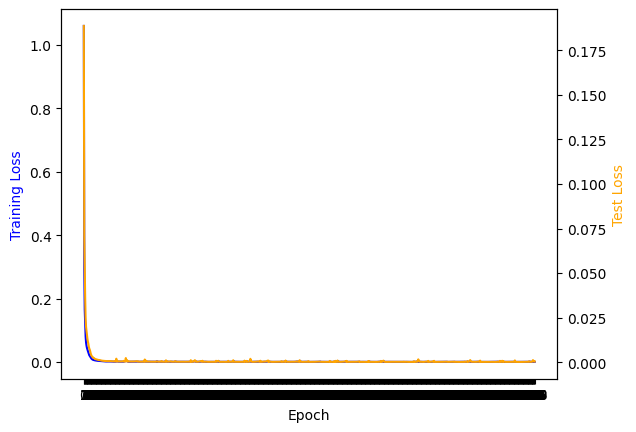

100%|██████████| 1000/1000 [00:34<00:00, 28.84it/s]

 Best Test Loss: 0.0001736203848849982


In [84]:
# Optimize model

network_dict = {
    "network": VariableANN,
    "kwargs": {"input_size": 6},
    "optimize_kwargs": {
        "dropout": {"name": "dropout", "low": 0.0, "high": 0.5, "step": 0.05},
        "neurons": {"name": "neurons", "low": 16, "high": 256, "step": 16, "multi": np.random.randint(3, 6)},
    },
}


optimizer_dict = {
    "optimizer": optim.Adam,
    "kwargs": {},
    "optimize_kwargs": {
        "lr": {"name": "lr", "low": 1e-5, "high": 1e-1, "log": True},
        "weight_decay": {"name": "weight_decay", "low": 1e-5, "high": 1e-3, "log": True},
    },
}

best_network, best_optimizer = model.optimize_network(
    trial_count, "minimize", network_dict, optimizer_dict, loss_fn, epochs
)

trained_net = model.train_model("Model1", best_network, best_optimizer, loss_fn, 1000, plot_output=True)

In [85]:
# TESTING
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")
valid_rmse, _, valid_predictions = model.validate_model(trained_net, "valid")

print(model.train_labels[1].mean())

RMSE: 0.000887
MAE: 0.00068
RMSE: 0.000945
MAE: 0.000706
0.0636742115020752


## Optimize

In [100]:
def run_fn(cp_width, cp_length, taper_length, grating_height):
    beam_angle = 30
    freq = freqs[0]
    feature_array = np.array((beam_angle, cp_width, cp_length, taper_length, grating_height, freq))
    feature_array = feature_array.reshape((1, -1))
    prediction = model.make_prediction(trained_net, True, feature_array, 1)

    # return prediction[0]
    return prediction[0]

In [101]:
method = tdd.MethodBayOpt(
    initial_iter=300,
    n_iter=100,
    acq_func='ucb',
    kappa=3,
    xi=0.9,
    seed=1,
)

param_cp_width = tdd.ParameterFloat(name="cp_width", span=(3, 4))
param_cp_length = tdd.ParameterFloat(name="cp_length", span=(7, 8))
param_taper_length = tdd.ParameterFloat(name="taper_length", span=(5, 7))
param_grating_height = tdd.ParameterFloat(name="grating_height", span=(50, 100))
predict_parameters = [param_cp_width, param_cp_length, param_taper_length, param_grating_height]

output_dir = "/home/matt/Documents/Flexcompute/grating_coupler/data"
design_space = tdd.DesignSpace(
    method=method,
    parameters=predict_parameters,
    task_name="gc_predict_1",
    folder_name="GCV1",
    path_dir=output_dir,
)

In [102]:
predict_results = design_space.run(run_fn, verbose=True)
predict_df = predict_results.to_dataframe()

12:21:04 BST Best Fit from Initial Solutions: 0.09                              
             

             Latest Best Fit on Iter 0: 0.091                                   
             

12:21:05 BST Latest Best Fit on Iter 1: 0.094                                   
             

12:21:29 BST Latest Best Fit on Iter 73: 0.094                                  
             

12:21:39 BST Best Result: 0.09354984015226364                                   
             Best Parameters: cp_length: 7.0 cp_width: 3.0 grating_height:      
             60.209828579692875 taper_length: 7.0                               
             

In [105]:
input_dict = {"beam_angle": 30}
input_dict.update(predict_results.optimizer.max['params'])

sim = make_sim(**input_dict)
sim_data = web.run(sim, task_name="best_predicted")

12:23:14 BST Created task 'best_predicted' with task_id                         
             'fdve-fd1ab092-15ad-4ed1-8c12-b49ce192cc37' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=37214;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fd1ab092-15ad-4ed1-8c12-b49ce192cc37\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=864254;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fd1ab092-15ad-4ed1-8c12-b49ce192cc37\taskId]8;;\]8;id=37214;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fd1ab092-15ad-4ed1-8c12-b49ce192cc37\=]8;;\]8;id=161354;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fd1ab092-15ad-4ed1-8c12-b49ce192cc37\fdve]8;;\]8;id=37214;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fd1ab092-15ad-4ed1-8c12-b49ce192cc37\-fd1ab092-15a]8;;\
             ]8;id=37214;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fd1ab092-15ad-4ed1-8c12-b49ce192cc37\d-4ed1-8c12-b49ce192cc37']8;;\.

Output()

12:23:16 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:23:29 BST status = preprocess

12:23:32 BST Maximum FlexCredit cost: 1.326. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

12:23:54 BST early shutoff detected at 12%, exiting.

             status = success

             View simulation result at                                          
             ]8;id=591634;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fd1ab092-15ad-4ed1-8c12-b49ce192cc37\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=403335;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fd1ab092-15ad-4ed1-8c12-b49ce192cc37\taskId]8;;\]8;id=591634;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fd1ab092-15ad-4ed1-8c12-b49ce192cc37\=]8;;\]8;id=516947;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fd1ab092-15ad-4ed1-8c12-b49ce192cc37\fdve]8;;\]8;id=591634;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fd1ab092-15ad-4ed1-8c12-b49ce192cc37\-fd1ab092-15a]8;;\
             ]8;id=591634;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fd1ab092-15ad-4ed1-8c12-b49ce192cc37\d-4ed1-8c12-b49ce192cc37']8;;\.

Output()

12:23:55 BST loading simulation from simulation_data.hdf5

In [106]:
sim_data["flux"].flux.sel(f=freq0)

<xarray.FluxDataArray ()> Size: 4B
array(0.09712379, dtype=float32)
Coordinates:
    f        float64 8B 1.934e+14
Attributes:
    units:      W
    long_name:  flux